In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from sklearn.model_selection import train_test_split
import numpy as np
import os

In [2]:
# Image size (height x width)
ih = 64
iw = 64

# Grayscale or RGB
ch = 'rgb'

# Batch size 
batch_size = 40000

# Layer adapt
ksize = 4 # Kernel size : was '4' for 64x64 image
ssize = 2 # Stride size : was '2' for 64x64 image

# Size of test set (in %)
testsize = 0.3

# Number of epochs in untrainable model
epoch_unt = 7

# Number of epochs in trainable model
epoch_t = 8

# Where computation is performed: Kaggle (0) or Local (1)
cenv = 1

In [3]:
if cenv == 0:
    print("Computation environment: Kaggle")
if cenv == 1:
    print("Computation environment: Local")

Computation environment: Local


**Create new directory for version**

In [8]:
if cenv == 1:
    # Create new folder with the name of the notebook and the version number
    new_dir = f"/Users/Max/Documents/GitHub/DenseNet/DenseNet-local-v003"

# Data

In [9]:
if cenv == 0:
    path_root = "/kaggle/input/thesis-data"
    
    # Directory where checkpoints of DCGAN are stored
    checkpoint_dir = "/kaggle/input/checkpoints" 

if cenv == 1:
    path_root = "C:/Users/Max/Documents/thesis_data"
    
    # Directory where checkpoints of DCGAN are stored
    checkpoint_dir = 'C:/Users/Max/Documents/GitHub/dcgan_kaggle_output/dcgan-kaggle-v002/checkpoints'
    

In [10]:
im_si = (ih, iw)

if(ch == 'rgb'):
    chnum = 3
elif(ch == 'grayscale'):
    chnum = 1

In [11]:
batches = ImageDataGenerator().flow_from_directory(
    directory  = path_root, 
    color_mode = ch, 
    target_size= (ih,iw), 
    interpolation="bicubic",
    class_mode = 'sparse',
    batch_size=batch_size
)
imgs, labels = next(batches)

Found 26548 images belonging to 11 classes.


In [12]:
processed_imgs = tf.keras.applications.resnet.preprocess_input(imgs)
labels = np.array(labels)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(processed_imgs, labels, test_size=testsize)

In [14]:
trainsize = len(X_train)
testsize = len(X_test)

print(f"Size of training data: {trainsize} | Shape of training data {X_train.shape}")
print(f"Size of training data: {testsize}  | Shape of training data {X_test.shape}")
print(f"Shape of training labels {y_train.shape}")
print(f"Shape of training labels {y_test.shape}")

Size of training data: 18583 | Shape of training data (18583, 64, 64, 3)
Size of training data: 7965  | Shape of training data (7965, 64, 64, 3)
Shape of training labels (18583,)
Shape of training labels (7965,)


# ResNet

In [11]:
base_model = tf.keras.applications.DenseNet121(weights = 'imagenet', include_top = False, input_shape = (64,64,3))

In [12]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(11, activation = 'softmax')(x)

In [13]:
head_model = Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [14]:
for layer in head_model.layers[:-8]:
    layer.trainable=False
    
for layer in head_model.layers[-8:]:
    layer.trainable=True

Callbacks

In [15]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
if cenv == 0:
    checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
if cenv == 1:
    checkpoint = ModelCheckpoint(f'{new_dir}/model.h5', verbose=1, save_best_only=True)


In [16]:
history = head_model.fit(
    X_train, 
    y_train,
    batch_size=64, 
    epochs=40, 
    validation_data=(X_test, y_test),
    callbacks = [anne, checkpoint]) # EPOCHS WAS 40

Epoch 1/40
291/291 [==============================] - 52s 130ms/step - loss: 0.3741 - accuracy: 0.9039 - val_loss: 0.3654 - val_accuracy: 0.8618

Epoch 00001: val_loss improved from inf to 0.36544, saving model to /Users/Max/Documents/GitHub/DenseNet/DenseNet-local-v003\model.h5
Epoch 2/40
291/291 [==============================] - 33s 114ms/step - loss: 0.3136 - accuracy: 0.9165 - val_loss: 13.6790 - val_accuracy: 0.5804

Epoch 00002: val_loss did not improve from 0.36544
Epoch 3/40
291/291 [==============================] - 33s 113ms/step - loss: 0.3095 - accuracy: 0.9129 - val_loss: 0.7786 - val_accuracy: 0.8051

Epoch 00003: val_loss did not improve from 0.36544
Epoch 4/40
291/291 [==============================] - 33s 112ms/step - loss: 0.2134 - accuracy: 0.9311 - val_loss: 0.1761 - val_accuracy: 0.9436

Epoch 00004: val_loss improved from 0.36544 to 0.17607, saving model to /Users/Max/Documents/GitHub/DenseNet/DenseNet-local-v003\model.h5
Epoch 5/40
291/291 [=====================

291/291 [==============================] - 33s 112ms/step - loss: 0.0743 - accuracy: 0.9761 - val_loss: 14.9961 - val_accuracy: 0.8593

Epoch 00040: val_loss did not improve from 0.13273


In [15]:
if cenv == 0:
    best_model = load_model("/kaggle/working/model.h5")
if cenv == 1:
    best_model = load_model(f"{new_dir}/model.h5")

In [16]:
scores = best_model.evaluate(X_test, y_test)
print(f"Overall CNN Accuracy: {scores[1]}\n(The number of correct predictions divided by the number of total predictions)")

249/249 [==============================] - 11s 30ms/step - loss: 0.1076 - accuracy: 0.9670
Overall CNN Accuracy: 0.966980516910553
(The number of correct predictions divided by the number of total predictions)


# Plots

In [17]:
multi_distribution = np.unique(labels, return_counts=True)

In [18]:
classes = batches.class_indices.keys()

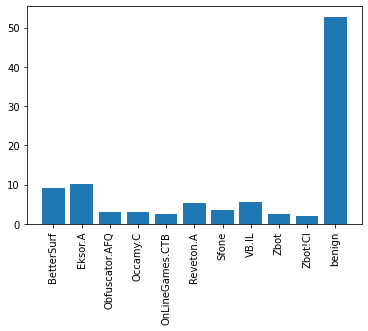

In [19]:
perc = (multi_distribution[1]/labels.shape[0])*100
plt.xticks(rotation='vertical')
plt.bar(classes,perc)
if cenv == 0:
    plt.savefig("multi_data_dist.png", bbox_inches = 'tight')
if cenv == 1:
    plt.savefig(f"{new_dir}/multi_data_dist.png", bbox_inches = 'tight')

In [20]:
def my_fmt(x):
    return '{:.1f}%\n({:.0f})'.format(x, total*x/100)
total = trainsize + testsize

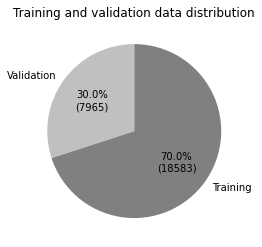

In [21]:
plt.pie(
    [trainsize, testsize], 
    labels = ["Training", "Validation"], 
    startangle=90, 
    counterclock=False, 
    autopct=my_fmt,
    colors = ['gray', 'silver']
)

plt.title("Training and validation data distribution")

if cenv == 0:
    plt.savefig("train_test_dist.png", bbox_inches = 'tight')
if cenv == 1:
    plt.savefig(f"{new_dir}/train_test_dist.png", bbox_inches = 'tight')

NameError: name 'history' is not defined

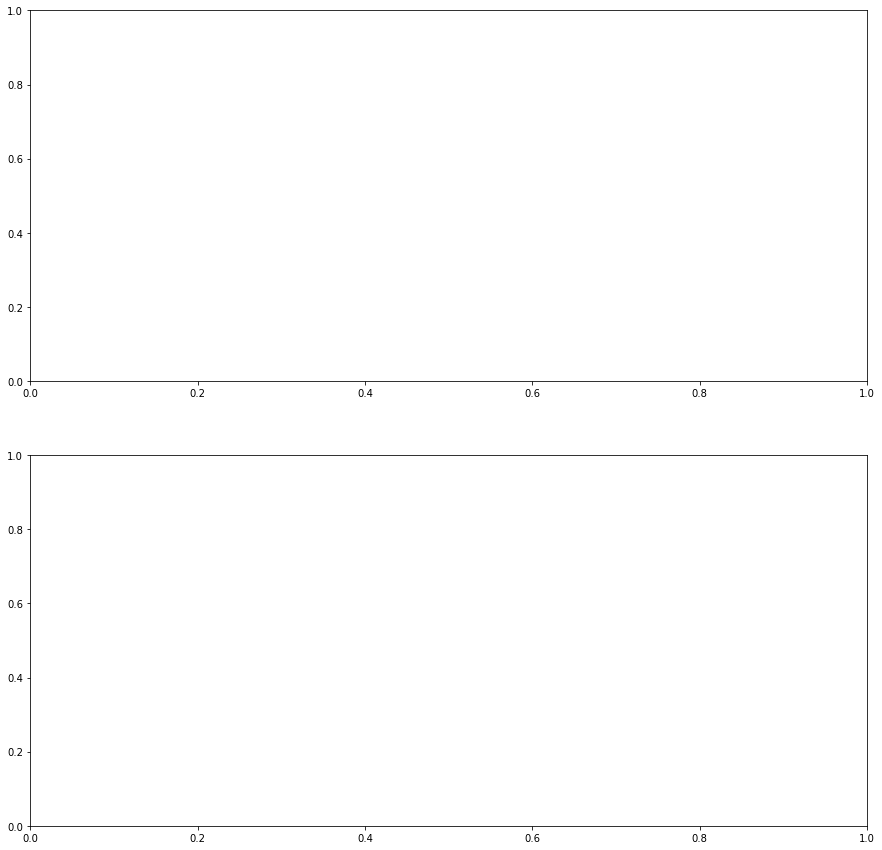

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

if cenv == 0:
    plt.savefig("performance_figure.png", bbox_inches = 'tight')
if cenv == 1:
    plt.savefig(f"{new_dir}/performance_figure.png", bbox_inches = 'tight')

# Analyse performance

**Multiclass classification**

In [23]:
from sklearn import metrics
import pandas as pd
import seaborn as sns
from prettytable import PrettyTable, MSWORD_FRIENDLY

Multiclass performance table

In [24]:
t = PrettyTable(['Metric', 'Performance'])
t.add_row(['Valididation accuracy', round(scores[1],4)])
t.add_row(['Validation loss', round(scores[0],4)])
t.header = True
t.align = "l"
t.title = "Perf. of multi-class classification - DenseNet"
print(t)

+------------------------------------------------+
| Perf. of multi-class classification - DenseNet |
+------------------------------+-----------------+
| Metric                       | Performance     |
+------------------------------+-----------------+
| Valididation accuracy        | 0.967           |
| Validation loss              | 0.1076          |
+------------------------------+-----------------+


In [25]:
# Saving PrettyTable
table = t.get_string()

if cenv == 0:
    with open('multi_performance_table.txt', 'w') as f:
        f.write(table)
if cenv == 1:
    with open(f'{new_dir}/multi_performance_table.txt', 'w') as f:
        f.write(table)

In [33]:
y_pred = np.argmax(best_model.predict(X_test), axis=-1)

In [34]:
y_pred

array([ 5,  3,  4, ..., 10,  7, 10], dtype=int64)

In [35]:
y_test2 = y_test
y_test2

array([ 8.,  3.,  4., ..., 10.,  7., 10.], dtype=float32)

In [36]:
c_matrix = metrics.confusion_matrix(y_test2, y_pred)

In [37]:
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if cenv == 0:
        plt.savefig("multi_class_cmatrix.png")
    if cenv == 1:
        plt.savefig(f"{new_dir}/multi_class_cmatrix.png")

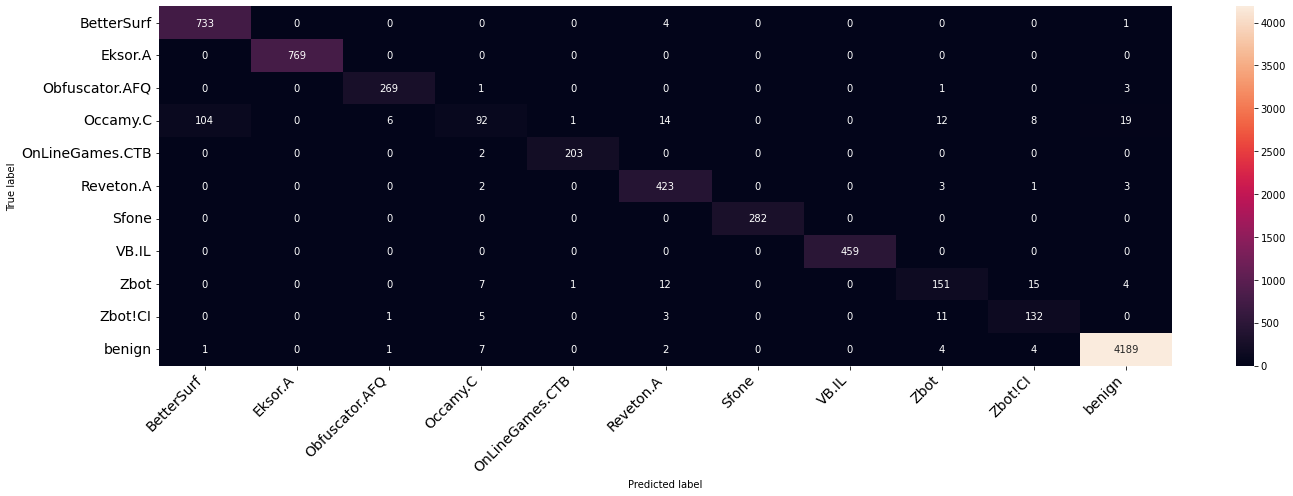

In [38]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)

**Binary classification**


In [39]:
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
from prettytable import PrettyTable, MSWORD_FRIENDLY

In [40]:
y_predbin = [] 
y_truebin = []
for count, value in enumerate(y_test2):
    if y_test2[count] in range(10): # range(10) is 0 to 9
        y_truebin.append(0)
    else: y_truebin.append(1)
    
    if y_pred[count] in range(10):
        y_predbin.append(0)
    else: y_predbin.append(1)
    
    continue
if len(y_truebin) == len(y_predbin):
    print(f"Length of the observations in test set: {len(y_truebin)}")

Length of the observations in test set: 7965


In [41]:
rw_count = 0
bn_count = 0
for count, value in enumerate(multi_distribution[1]):
    if count in range(10):
        rw_count = rw_count + multi_distribution[1][count]
    else: 
        bn_count = bn_count + multi_distribution[1][count]
print(f"Ransomware Occurences: {rw_count}, Benign Occurences: {bn_count}")

Ransomware Occurences: 12536, Benign Occurences: 14012


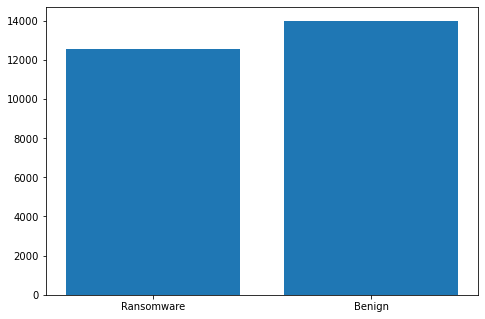

In [42]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x_lab = ['Ransomware', 'Benign']
y_lab = [rw_count, bn_count]
ax.bar(x_lab, y_lab)
if cenv == 0:
    plt.savefig("data_dist.png.png", bbox_inches = 'tight')
if cenv == 1:
    plt.savefig(f"{new_dir}/bin_data_dist.png", bbox_inches = 'tight')

In [43]:
c_matrix_bin = metrics.confusion_matrix(y_truebin, y_predbin)

In [44]:
def confusion_matrix_bin(confusion_matrix, class_names_bin, figsize = (5,2), fontsize=7):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names_bin, columns=class_names_bin, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("DenseNet121")
    if cenv == 0:
        plt.savefig("bin_class_cmatrix.png", bbox_inches = 'tight')
    if cenv == 1:
        plt.savefig(f"{new_dir}/bin_class_cmatrix.png", bbox_inches = 'tight')

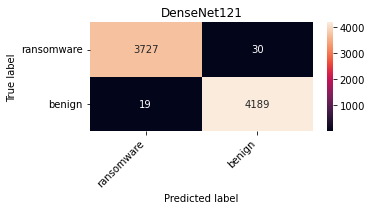

In [45]:
class_names_bin= ("ransomware", "benign")
confusion_matrix_bin(c_matrix_bin, class_names_bin, figsize = (5,2), fontsize=10)

**True Positive Rate**

In [46]:
TPR = c_matrix_bin[0,0]/(c_matrix_bin[0,0] + c_matrix_bin[0,1]) #True Positive Rate

**Accuracy**

In [47]:
ACC = accuracy_score(y_truebin, y_predbin) # Accuracy

**F1 Score**

In [48]:
F1 = f1_score(y_truebin, y_predbin, labels=0) # F1 Score

**Matthews Correlation Coefficient**

In [49]:
MCC = matthews_corrcoef(y_truebin, y_predbin) # Matthews Correlation Coefficient

In [50]:
t = PrettyTable(['Metric', 'Performance'])
t.add_row(['True Positive Rate', round(TPR,4)])
t.add_row(['Accuracy', round(ACC,4)])
t.add_row(['F1 Score', round(F1,4)])
t.add_row(['Matthews Correlation Coefficient', round(MCC,4)])
t.header = True
t.align = "l"
t.title = "Performance of DenseNet"
print(t)

+------------------------------------------------+
|            Performance of DenseNet             |
+----------------------------------+-------------+
| Metric                           | Performance |
+----------------------------------+-------------+
| True Positive Rate               | 0.992       |
| Accuracy                         | 0.9938      |
| F1 Score                         | 0.9942      |
| Matthews Correlation Coefficient | 0.9877      |
+----------------------------------+-------------+


In [51]:
# Saving PrettyTable
table = t.get_string()

if cenv == 0:
    with open('bin_performance_table.txt', 'w') as f:
        f.write(table)
if cenv == 1:
    with open(f'{new_dir}/bin_performance_table.txt', 'w') as f:
        f.write(table)